# iCAT Alignment
---
Overview and interactive walkthrough of how to align (part of) an individual section using `render-python`. Assumes image data has already been imported following the [iCAT-import workflow](https://github.com/lanery/iCAT-workflow/blob/master/notebooks/iCAT-import.ipynb).

## 1 Generate Point Matches
---

### 1.0 Imports

In [53]:
# Libraries needed
import re
from functools import partial
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import renderapi

### 1.1 Setup render Environment

In [2]:
owner = 'rlane'  # replace with your name
project = 'iCAT_align'

# Create a renderapi.connect.Render object
render_connect_params = {
    'host': 'sonic',
    'port': 8080,
    'owner': owner,
    'project': project,
    'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
    'memGB': '2G'
}

render = renderapi.connect(**render_connect_params)
stacks = renderapi.render.get_stacks_by_owner_project(render=render)
match_collections = {}
for stack in stacks:
    match_collections[stack] = f'{stack}_points'

### 1.2 Get Tile Pairs
Tile pairs are any two tiles that overlap with each other (including diagonally). There are useful functions in the `renderapi` for generating lists of tile pairs.

In [15]:
# Initialize dicts
stack_bounds = {}
tile_pairs = {}
tile_pair_lists = {}

for stack in stacks:
    
    # Get positional bounds of image stack
    stack_bound = renderapi.stack.get_stack_bounds(stack, render=render)
    stack_bounds[stack] = stack_bound
    
    # Only attempt to get tile pairs if stack contains >1 tiles
    N_tiles = len(renderapi.stack.get_stack_tileIds(stack, render=render))
    if N_tiles > 1:
        
        # Generate tile pairs for input into point match generator
        tile_pairs[stack] = renderapi.client.tilePairClient(stack,
                                                            minz=stack_bounds[stack]['minZ'],
                                                            maxz=stack_bounds[stack]['maxZ'],
                                                            render=render)
        
        # Generate list of tile pairs    
        tile_pair_list = [(tp['p']['id'], tp['q']['id']) for tp in tile_pairs[stack]['neighborPairs']]
        tile_pair_lists[stack] = tile_pair_list
        
# Preview first several tile pairs
tile_pair_lists['lil_EM'][:8]

[('aaa_lil_EM-00000x00005', 'aan_lil_EM-00000x00004'),
 ('aaa_lil_EM-00000x00005', 'aab_lil_EM-00001x00005'),
 ('aab_lil_EM-00001x00005', 'aam_lil_EM-00001x00004'),
 ('aab_lil_EM-00001x00005', 'aac_lil_EM-00002x00005'),
 ('aac_lil_EM-00002x00005', 'aal_lil_EM-00002x00004'),
 ('aac_lil_EM-00002x00005', 'aad_lil_EM-00003x00005'),
 ('aad_lil_EM-00003x00005', 'aak_lil_EM-00003x00004'),
 ('aad_lil_EM-00003x00005', 'aae_lil_EM-00004x00005')]

### 1.3 Run Point Match Client
First create a wrapper for `renderapi.client.pointMatchClient` so that we can run the point match client on multiple threads with `renderapi.client.WithPool`.

In [4]:
def run_point_match_client(tile_pair_chunk, stack, collection, render):
    """
    Point match client wrapper for use in multiprocessing
    """
    renderapi.client.pointMatchClient(stack=stack,
                                      collection=collection,
                                      tile_pairs=tile_pair_chunk,
                                      render=render)

Now break the tile pairs into chunks to prevent a java heap space out of memory error.

In [5]:
chunk_size = 6
tile_pair_chunks = {}

for stack, tile_pair_list in tile_pair_lists.items():
    tile_pair_chunks[stack] = []
    
    for i in range(0, len(tile_pair_list), chunk_size):
        
        tile_pair_chunk = tile_pair_list[i : i+chunk_size]
        tile_pair_chunks[stack].append(tile_pair_chunk)

Now run the point match client (the function that actually finds features and whatnot) over the chunks of tile pairs. Have to use `partial` with `WithPool` because otherwise it would be too easy. Not sure if it actually runs on multiple cores when run through a Jupyter notebook. Will have to do timing tests at some point. Adjust `N_cores` as necessary.

In [6]:
N_cores = 30

for stack, tile_pair_chunk in tile_pair_chunks.items():
    
    point_match_client_partial = partial(run_point_match_client,
                                         stack=stack,
                                         collection=match_collections[stack],
                                         render=render)
    
    with renderapi.client.WithPool(N_cores) as pool:
        pool.map(point_match_client_partial, tile_pair_chunks[stack])

### 1.4 Basic Point Match Analysis
Loop over tile pairs to aggregate East-West and North-South point matches

In [74]:
EW_point_matches = np.full([6, 7], -1)
NS_point_matches = np.full([6, 7], -1)

for stack, tile_pair_list in tile_pair_lists.items():
    
    for tile_pair in tile_pair_list:
    
        # Get group IDs
        groupIds = renderapi.pointmatch.get_match_groupIds(match_collections[stack], render=render)

        tile_pair_matches = renderapi.pointmatch.get_matches_from_tile_to_tile(
                                match_collections[stack],
                                pgroup=groupIds[0],
                                pid=tile_pair[0],
                                qgroup=groupIds[0],
                                qid=tile_pair[1],
                                render=render)
        
        # Suss out column and row number from tileId
        pc, pr = [int(i) for i in re.findall('\d+', tile_pair[0])]
        qc, qr = [int(i) for i in re.findall('\d+', tile_pair[1])]
                                
        try:
            # Stuff matches into arrays
            p_matches = np.array(tile_pair_matches[0]['matches']['p']).T
            q_matches = np.array(tile_pair_matches[0]['matches']['q']).T
            # Ensure p and q matches check out
            assert len(p_matches) == len(q_matches)
                        
        except IndexError:
            # No matches for this tile pair
            p_matches = []
            q_matches = []
            
        # East-West match (same row)
        if pr == qr:
            EW_point_matches[pr, min(pc, qc)] = len(p_matches)

        # North-West match (same column)
        else: #  pc == qc
            NS_point_matches[min(pr, qr), pc] = len(p_matches)

### 1.5 Plot Point Matches

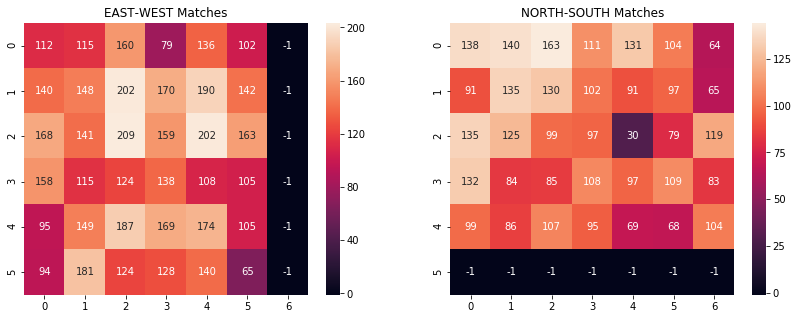

In [78]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 5))

sns.heatmap(EW_point_matches, ax=ax1, annot=True, fmt='.0f', robust=True);
sns.heatmap(NS_point_matches, ax=ax2, annot=True, fmt='.0f', robust=True);
ax1.set_title('EAST-WEST Matches');
ax2.set_title('NORTH-SOUTH Matches');

## Run EM Aligner